## 환경 준비

In [1]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt -O requirements.txt
!pip install -r requirements.txt
!pip install tensorflow==2.2.0

--2021-10-09 11:14:11--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     610  --.-KB/s    in 0s      

2021-10-09 11:14:11 (29.7 MB/s) - ‘requirements.txt’ saved [610/610]

     |████████████████████████████████| 17.3 MB 30 kB/s 
     |████████████████████████████████| 1.4 MB 26.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 769 kB 42.8 MB/s 
     |████████████████████████████████| 1.0 MB 41.1 MB/s 
     |████████████████████████████████| 46.9 MB 39 kB/s 
     |████████████████████████████████| 252 kB 45.1 MB/s 
     |█

## 데이터 다운로드

In [2]:
!mkdir -p data_in/KOR/naver_movie
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/naver_movie/ratings_train.txt \
              -O data_in/KOR/naver_movie/ratings_train.txt
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/naver_movie/ratings_test.txt \
              -O data_in/KOR/naver_movie/ratings_test.txt

--2021-10-09 11:16:21--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/naver_movie/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘data_in/KOR/naver_movie/ratings_train.txt’

data_in/KOR/naver_m 100%[===================>]  13.95M  --.-KB/s    in 0.1s    

2021-10-09 11:16:22 (101 MB/s) - ‘data_in/KOR/naver_movie/ratings_train.txt’ saved [14628807/14628807]

--2021-10-09 11:16:22--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/naver_movie/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.gi

In [3]:
import os
import tensorflow as tf
from transformers import TFGPT2LMHeadModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

아레 실행 커멘드는 gpt_ckpt 폴더가 있지 않은 경우에만 실행해주세요.

In [4]:
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [5]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

## 프롬프트 튜닝 모델 구현

In [7]:
class TFGPT2PtuningClassifier(tf.keras.Model):
    def __init__(self, dir_path):
        super(TFGPT2PtuningClassifier, self).__init__()
        
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        self.gpt2.trainable = False

        self.prompt_embedding_size = self.gpt2.config.hidden_size
        self.prompt_emgedding = tf.keras.layers.Embedding(2, self.prompt_embedding_size, name='prompt_embedding')
        
        self.bilstm = tf.keras.Sequential(name='prompt_bilstm')
        self.bilstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.prompt_embedding_size, return_sequences=True)))
        self.bilstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.prompt_embedding_size, return_sequences=True)))
        
        self.mlp = tf.keras.Sequential(name='prompt_mlp')
        self.mlp.add(tf.keras.layers.Dense(self.prompt_embedding_size))
        self.mlp.add(tf.keras.layers.ReLU())
        self.mlp.add(tf.keras.layers.Dense(self.prompt_embedding_size))

    def generate_prompt_input(self, inputs_ids):
        inputs_embeds = self.gpt2.transformer.wte(inputs_ids[:, 1:-1])

        prompt_indexs = tf.concat([inputs_ids[:, 0:1], inputs_ids[:, -1:]], axis=-1)
        prompt_embeds = self.prompt_emgedding(prompt_indexs)
        prompt_embeds = self.bilstm(prompt_embeds)
        prompt_embeds = self.mlp(prompt_embeds)
  
        prompt_updated_inputs = tf.concat([prompt_embeds[:, 0:1, :], inputs_embeds, 
                                  prompt_embeds[:, 1:, :]],
                                  axis=1)
        
        return prompt_updated_inputs
        
    def call(self, inputs):
        input_ids = inputs[0]
        attention_mask = inputs[1] if len(inputs) > 1 else None

        inputs_embeds = self.generate_prompt_input(input_ids)
        outputs = self.gpt2({'inputs_ids': None, 'inputs_embeds': inputs_embeds, 'attention_mask': attention_mask})[0][:, -1, :]

        return outputs

## 프롬프트 튜닝을 위한 네이버 영화 리뷰 데이터 전처리

In [8]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [9]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [10]:
DATA_IN_PATH = './data_in/KOR'
DATA_OUT_PATH = "./data_out/KOR"

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()

In [11]:
# train_data = train_data[:50] # for test

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

def add_prompt_token(tokens):
    return [0] + tokens + [1]

train_data_sents = []
train_attn_mask = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_text_label = '긍정' if train_label == 1 else '부정'

    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens = add_prompt_token(tokens)

    train_attn_mask.append([1 if t != 3 else 0 for t in tokens])
    train_data_sents.append(tokens)

    label = vocab[tokenizer('긍정')] if train_label == 1 else vocab[tokenizer('부정')]
    train_data_labels.append(label)


train_attn_mask = np.array(train_attn_mask, dtype=np.int64)
train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [12]:
print('입력 토큰 인덱스: ', train_data_sents[0])
print('어텐션 마스크: ', train_attn_mask[0])
print('정답 라벨: ', train_data_labels[0])

입력 토큰 인덱스:  [    0     0   134   280 48212  7175  5895 47643 47491  7974  9092     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     1]
어텐션 마스크:  [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1]
정답 라벨:  [2473]


## 네이버 영화 리뷰 감정 분석을 위한 프롬프트 튜닝 학습 

In [13]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2PtuningClassifier(dir_path=BASE_MODEL_PATH)

All model checkpoint weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [15]:
model_name = "tf2_gpt2_ptuning_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit((train_data_sents, train_attn_mask), train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT, 
                        callbacks=[earlystop_callback, cp_callback])

./data_out/KOR/tf2_gpt2_ptuning_naver_movie -- Folder create complete 

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.7602
Epoch 00001: val_accuracy improved from -inf to 0.81713, saving model to ./data_out/KOR/tf2_gpt2_ptuning_naver_movie/weights.h5
4219/4219 [==============================] - 2507s 594ms/step - loss: 0.6264 - accuracy: 0.7602 - val_loss: 0.4066 - val_accuracy: 0.8171
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.7906
Epoch 00002: val_accuracy improved from 0.81713 to 0.82100, saving model to ./data_out/KOR/tf2_gpt2_ptuning_naver_movie/weights.h5
4219/4219 [==============================] - 2514s 596ms/step - loss: 0.4626 - accuracy: 0.7906 - val_loss: 0.4006 - val_accuracy: 0.8210
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.7987
Epoch 00003: val_accuracy improved from 0.82100 to 0.82633, saving model to ./data_out/KOR/tf2_gpt2_pt

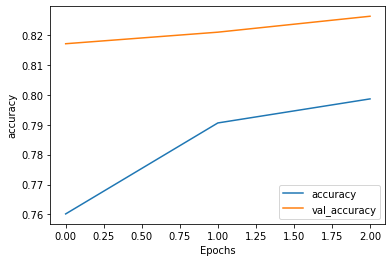

In [16]:
plot_graphs(history, 'accuracy')

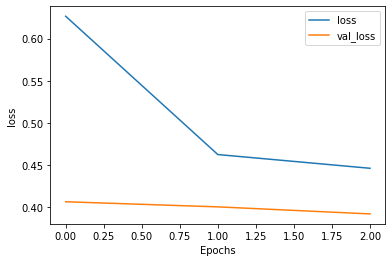

In [17]:
plot_graphs(history, 'loss')

## 네이버 영화 리뷰 모델 프롬프트 튜닝 테스트


In [18]:
test_data = pd.read_csv(DATA_TEST_PATH, header=0, delimiter='\t', quoting=3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [19]:
# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []
test_attn_mask = []

pred_tokens = []


for test_sent, test_label in test_data[['document', 'label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = []
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens = add_prompt_token(tokens)
    test_data_sents.append(tokens)
    mask = [1 if t != 3 else 0 for t in tokens]
    test_attn_mask.append(mask)

    label = vocab[tokenizer('긍정')] if test_label == 1 else vocab[tokenizer('부정')]
    test_data_labels.append(label)
    
test_attn_mask = np.array(test_attn_mask, dtype=np.int64)
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [20]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [21]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate((test_data_sents, test_attn_mask), test_data_labels, batch_size=512)
print("test loss, test acc: ", results)

98/98 [==============================] - 330s 3s/step - loss: 0.4080 - accuracy: 0.8167
test loss, test acc:  [0.4080306589603424, 0.8167089819908142]


In [1]:
from tqdm import tqdm

# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []
test_attn_mask = []

pred_tokens = []

for test_sent, test_label in tqdm(test_data[['document','label']].values):

    tokens = []  
    tokens += vocab[tokenizer(clean_text(test_sent) )]
    tokens = add_prompt_token(tokens)

    pred_tokens.append(tf.argmax(cls_model((np.array([tokens], dtype=np.int64), None)), axis=-1).numpy()[0])
    

    label = vocab[tokenizer('긍정')] if test_label == 1 else vocab[tokenizer('부정')]
    test_data_labels.append(label[0])
    
# test_data_sents = np.array(test_data_sents, dtype=np.int64)
# test_data_labels = np.array(test_data_labels, dtype=np.int64)

NameError: ignored

In [ ]:
accuracy_match = [p == t for p, t in zip(pred_tokens, test_data_labels)]
accuracy = len([m for m in accuracy_match if m]) / len(test_data_labels)

accuracy